## Load data

In [3]:
import os
os.chdir('..')

In [ ]:
from src.dataset import *
from src.model import *
from src.train_test import *
import matplotlib.pyplot as plt
import pandas as pd
from torch import optim
from src.vis import *
from src.gradient import *

In [11]:
batch_size = 32
model_name = 'CIFAR17'
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [4]:
# load data
train_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=True)
test_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=False)    


Files already downloaded and verified
Files already downloaded and verified


## Original model

In [13]:
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  1%|          | 8/1563 [00:00<00:21, 71.45it/s]

Test set: Average loss: 0.8211, Accuracy: 35700/50000 (71%)

Trail 2


  1%|          | 8/1563 [00:00<00:20, 77.54it/s]

Test set: Average loss: 0.8266, Accuracy: 35509/50000 (71%)

Trail 3


  0%|          | 7/1563 [00:00<00:24, 63.76it/s]

Test set: Average loss: 0.8477, Accuracy: 35142/50000 (70%)

Trail 4


100%|██████████| 1563/1563 [00:16<00:00, 94.23it/s] 


Test set: Average loss: 0.8119, Accuracy: 35776/50000 (72%)



  1%|          | 10/1563 [00:00<00:16, 91.90it/s]

Trail 5


  1%|          | 11/1563 [00:00<00:14, 108.55it/s]

Test set: Average loss: 0.8619, Accuracy: 34810/50000 (70%)

Trail 6


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.8297, Accuracy: 35361/50000 (71%)

Trail 7


  1%|          | 15/1563 [00:00<00:10, 145.80it/s]

Test set: Average loss: 0.8539, Accuracy: 35084/50000 (70%)

Trail 8


  1%|          | 15/1563 [00:00<00:10, 143.33it/s]

Test set: Average loss: 0.7805, Accuracy: 36359/50000 (73%)

Trail 9


  1%|          | 15/1563 [00:00<00:10, 145.31it/s]

Test set: Average loss: 0.8107, Accuracy: 35883/50000 (72%)

Trail 10


  1%|          | 15/1563 [00:00<00:10, 142.42it/s]

Test set: Average loss: 0.8277, Accuracy: 35474/50000 (71%)

Trail 11


  1%|          | 14/1563 [00:00<00:11, 132.69it/s]

Test set: Average loss: 0.8190, Accuracy: 35625/50000 (71%)

Trail 12


  1%|          | 8/1563 [00:00<00:19, 77.77it/s]

Test set: Average loss: 0.8868, Accuracy: 34380/50000 (69%)

Trail 13


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.8806, Accuracy: 34455/50000 (69%)

Trail 14


  1%|          | 8/1563 [00:00<00:20, 74.80it/s]

Test set: Average loss: 0.8145, Accuracy: 35717/50000 (71%)

Trail 15


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.7816, Accuracy: 36160/50000 (72%)

Trail 16


  1%|          | 9/1563 [00:00<00:18, 81.96it/s]

Test set: Average loss: 0.7854, Accuracy: 36211/50000 (72%)

Trail 17


  1%|          | 8/1563 [00:00<00:19, 77.88it/s]

Test set: Average loss: 0.8026, Accuracy: 35957/50000 (72%)

Trail 18


  1%|          | 15/1563 [00:00<00:10, 144.55it/s]

Test set: Average loss: 0.8222, Accuracy: 35467/50000 (71%)

Trail 19


  1%|          | 14/1563 [00:00<00:11, 139.87it/s]

Test set: Average loss: 0.8065, Accuracy: 35824/50000 (72%)

Trail 20


100%|██████████| 1563/1563 [00:09<00:00, 168.15it/s]


Test set: Average loss: 0.8225, Accuracy: 35594/50000 (71%)



  1%|          | 14/1563 [00:00<00:11, 135.56it/s]

Trail 21


  1%|          | 15/1563 [00:00<00:10, 143.51it/s]

Test set: Average loss: 0.8477, Accuracy: 35032/50000 (70%)

Trail 22


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.8090, Accuracy: 35829/50000 (72%)

Trail 23


  1%|          | 11/1563 [00:00<00:14, 108.78it/s]

Test set: Average loss: 0.8079, Accuracy: 35879/50000 (72%)

Trail 24


100%|██████████| 1563/1563 [00:16<00:00, 96.86it/s] 


Test set: Average loss: 0.8596, Accuracy: 34750/50000 (70%)



  1%|          | 8/1563 [00:00<00:20, 74.27it/s]

Trail 25


  0%|          | 7/1563 [00:00<00:23, 66.58it/s]

Test set: Average loss: 0.8150, Accuracy: 35827/50000 (72%)

Trail 26


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.8776, Accuracy: 34565/50000 (69%)

Trail 27


  1%|          | 8/1563 [00:00<00:21, 71.82it/s]

Test set: Average loss: 0.7926, Accuracy: 35985/50000 (72%)

Trail 28


  1%|          | 8/1563 [00:00<00:20, 77.74it/s]

Test set: Average loss: 0.8389, Accuracy: 34936/50000 (70%)

Trail 29


  1%|          | 14/1563 [00:00<00:11, 138.69it/s]

Test set: Average loss: 0.8342, Accuracy: 35156/50000 (70%)

Trail 30


100%|██████████| 1563/1563 [00:09<00:00, 163.63it/s]


Test set: Average loss: 0.8228, Accuracy: 35605/50000 (71%)



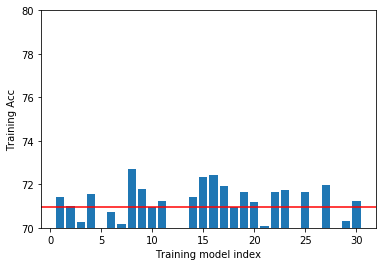

Average training acc: 70.9368


[71.4,
 71.018,
 70.284,
 71.552,
 69.62,
 70.722,
 70.168,
 72.718,
 71.766,
 70.948,
 71.25,
 68.76,
 68.91,
 71.434,
 72.32,
 72.422,
 71.914,
 70.934,
 71.648,
 71.188,
 70.064,
 71.658,
 71.758,
 69.5,
 71.654,
 69.13,
 71.97,
 69.872,
 70.312,
 71.21]

In [14]:
plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', total_trails=30)

### Get correct predicted training data index for each model

In [15]:
# 
correct_index_list = dict()
for trail in range(1, 31):
    correct_index_list[str(trail)] = [] # initialize
    
    checkpoint = 'checkpoints/CIFAR17-CIFAR10-model{}/199.pt'.format(trail)
    model.load_state_dict(torch.load(checkpoint))
    print('Trail {}'.format(str(trail)))
    correct_index = test_correct(model, train_data_loader)
    correct_index_list[str(trail)] = correct_index


  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  1%|          | 18/1563 [00:00<00:08, 175.19it/s]

Trail 2


  1%|          | 18/1563 [00:00<00:08, 175.37it/s]

Trail 3


  1%|          | 18/1563 [00:00<00:08, 179.56it/s]

Trail 4


  1%|          | 18/1563 [00:00<00:08, 173.69it/s]

Trail 5


  1%|          | 8/1563 [00:00<00:19, 79.27it/s]

Trail 6


  1%|          | 9/1563 [00:00<00:19, 80.10it/s]

Trail 7


  1%|          | 12/1563 [00:00<00:13, 113.11it/s]

Trail 8


  1%|          | 12/1563 [00:00<00:13, 112.66it/s]

Trail 9


  1%|          | 14/1563 [00:00<00:11, 139.53it/s]

Trail 10


  1%|          | 8/1563 [00:00<00:19, 79.47it/s]

Trail 11


  1%|          | 15/1563 [00:00<00:10, 148.95it/s]

Trail 12


  1%|          | 17/1563 [00:00<00:09, 162.50it/s]

Trail 13


  1%|          | 15/1563 [00:00<00:10, 149.85it/s]

Trail 14


  1%|          | 18/1563 [00:00<00:08, 176.81it/s]

Trail 15


  1%|          | 14/1563 [00:00<00:11, 137.14it/s]

Trail 16


  1%|          | 18/1563 [00:00<00:08, 175.38it/s]

Trail 17


  1%|          | 15/1563 [00:00<00:10, 143.40it/s]

Trail 18


  1%|          | 18/1563 [00:00<00:08, 172.94it/s]

Trail 19


  1%|          | 11/1563 [00:00<00:14, 107.04it/s]

Trail 20


  1%|          | 12/1563 [00:00<00:14, 110.40it/s]

Trail 21


  1%|          | 11/1563 [00:00<00:14, 108.33it/s]

Trail 22


  1%|          | 8/1563 [00:00<00:20, 75.86it/s]

Trail 23


  0%|          | 7/1563 [00:00<00:24, 63.24it/s]

Trail 24


  1%|          | 12/1563 [00:00<00:13, 115.74it/s]

Trail 25


  1%|          | 15/1563 [00:00<00:10, 149.59it/s]

Trail 26


  1%|          | 17/1563 [00:00<00:09, 162.66it/s]

Trail 27


  1%|          | 14/1563 [00:00<00:11, 138.81it/s]

Trail 28


  1%|          | 18/1563 [00:00<00:09, 170.98it/s]

Trail 29


  1%|          | 18/1563 [00:00<00:08, 176.83it/s]

Trail 30


100%|██████████| 1563/1563 [00:08<00:00, 176.12it/s]


### Plot histogram of number of times that a model correctly predict it out of 30 models in total 

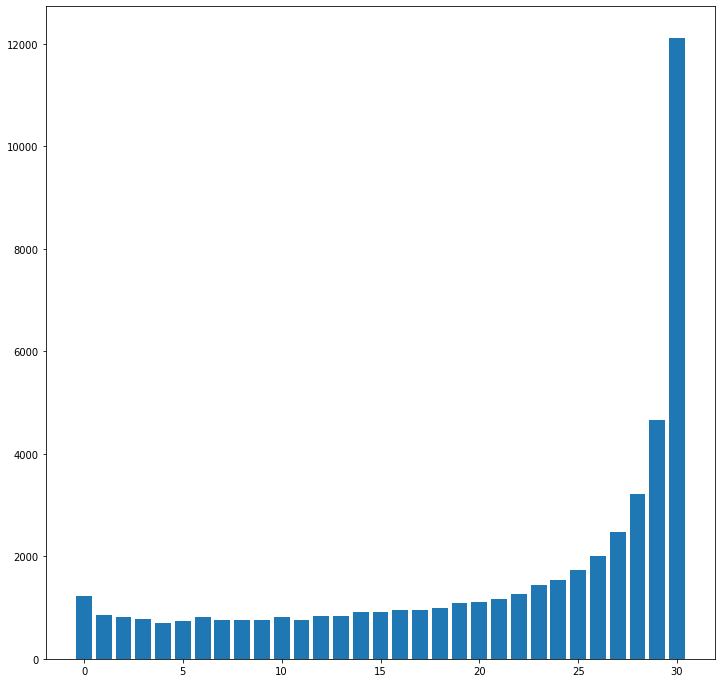

In [24]:
# 
df = pd.DataFrame.from_dict(correct_index_list)
correct_times = list(df.agg("sum", axis="columns"))

plt.bar(range(0, 31), [np.sum(np.asarray(correct_times)==i) for i in range(0, 31)])
plt.show()

### Record positive samples (>=25 times correct) and negative sample (<=5 times correct)

In [25]:
pos_index = np.where(np.asarray(correct_times) >= 25)[0]
neg_index = np.where(np.asarray(correct_times) <= 5)[0]

np.save('datasets/CIFAR_train_pos_index', pos_index)
np.save('datasets/CIFAR_train_neg_index', neg_index)

In [26]:
# create loader for positive samples and negative samples
pos_index = np.load('datasets/CIFAR_train_pos_index.npy')
neg_index = np.load('datasets/CIFAR_train_neg_index.npy')

train_data_loader_pos = data_loader(batch_size=1,  # batch size must be 1
                                    dataset_name = 'CIFAR10', 
                                    subsample_id=pos_index.tolist(), 
                                    train=True,
                                    shuffle=False) # shuffle should be disabled

train_data_loader_neg = data_loader(batch_size=1, 
                                    dataset_name = 'CIFAR10', 
                                    subsample_id=neg_index.tolist(), 
                                    train=True,
                                    shuffle=False) # shuffle should be disabled

Files already downloaded and verified
Files already downloaded and verified


In [27]:
print(len(pos_index))
print(len(neg_index))
print(len(train_data_loader_pos))
print(len(train_data_loader_neg))

26210
5122
26210
5122


### Gradient computation for pos and neg 

In [28]:
# get average gradient for pos samples and neg samples
trail = 1
checkpoint = 'checkpoints/CIFAR17-CIFAR10-model{}/199.pt'.format(trail)
model.load_state_dict(torch.load(checkpoint))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
print('Trail {}'.format(str(trail)))

pos_grad_dict = record_grad(model, train_data_loader_pos, 
                            criterion=nn.CrossEntropyLoss(reduction='sum'), 
                            optimizer=optimizer) # should use reduction method to be sum

 
    
neg_grad_dict = record_grad(model, train_data_loader_neg, 
                            criterion=nn.CrossEntropyLoss(reduction='sum'), 
                            optimizer=optimizer)


  0%|          | 19/26210 [00:00<02:20, 186.60it/s]

Trail 1
Length of dataloader 26210


  0%|          | 16/5122 [00:00<00:31, 159.66it/s]

Length of dataloader 5122


100%|██████████| 5122/5122 [00:28<00:00, 178.91it/s]


### Weights contradiction visualization

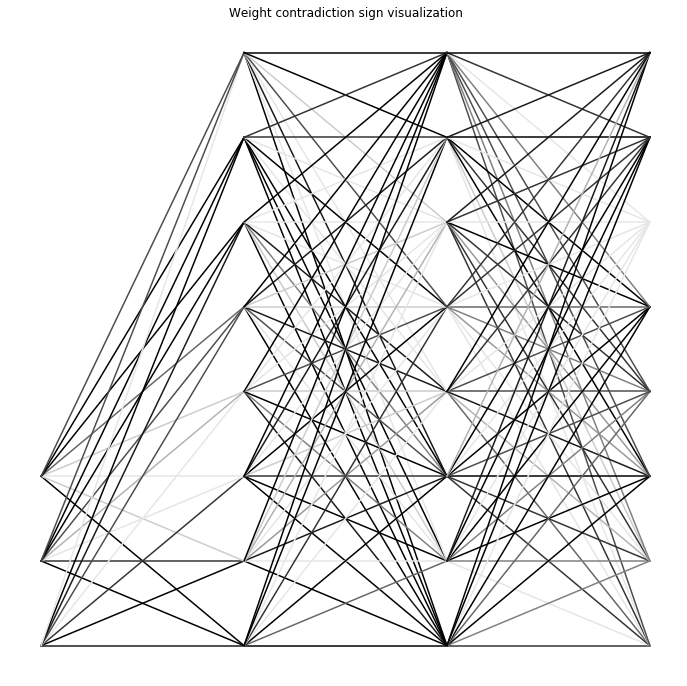

tensor([[1.1894, 1.5480, 1.3681],
        [1.2522, 0.8672, 0.1058],
        [2.1257, 0.0000, 0.0000],
        [0.0000, 0.1095, 0.0589],
        [0.7722, 0.7870, 0.8283],
        [0.8729, 1.2797, 1.8135],
        [3.1019, 4.7708, 9.2661],
        [0.0000, 0.6449, 0.8002]])
tensor([[0.9063, 0.9186, 0.8400, 0.8140, 0.7601, 0.7761, 0.6041, 1.2362],
        [0.2705, 0.0000, 0.3058, 0.2374, 0.0000, 0.0452, 0.7179, 0.0000],
        [0.8280, 0.4371, 0.1612, 0.7813, 0.1605, 0.0809, 0.6785, 0.3044],
        [0.0000, 0.1114, 0.0064, 0.0506, 0.2289, 0.2818, 0.0000, 0.0000],
        [0.5714, 0.0000, 0.6578, 0.8958, 0.0845, 0.0000, 1.0053, 0.7225],
        [0.0000, 0.0290, 0.0000, 0.0000, 0.0096, 0.0000, 0.0000, 0.0197],
        [0.1719, 0.0287, 0.1640, 0.0000, 0.4896, 0.0000, 0.1361, 0.4979],
        [0.6588, 2.3809, 0.5823, 1.0269, 1.9627, 1.4911, 0.2267, 1.3762]])
tensor([[0.3369, 0.0000, 0.1662, 0.0502, 0.0000, 0.1514, 0.0000, 0.0966],
        [0.4372, 0.7224, 0.9138, 0.0824, 0.0000, 0.6896, 0.0

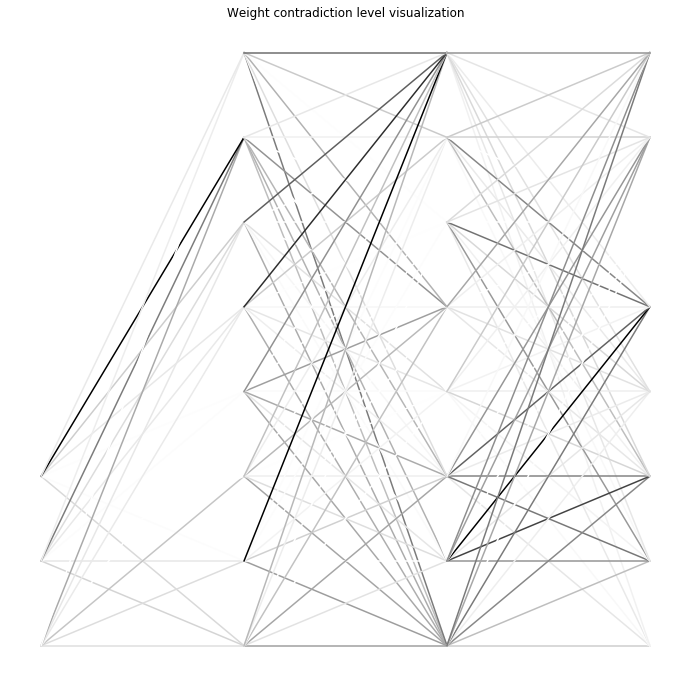

In [29]:
weight_contradict(pos_grad_dict, neg_grad_dict, method='sign')
weight_contradict(pos_grad_dict, neg_grad_dict, method='level')

### Get layer contradiction level

In [30]:
# avg/max of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name and 'conv' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.sum(dim=(2, 3)) # sum over kernel size

        layer_conflict_level = conflict_level.mean().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 1.3984216451644897
body.cnn2.conv.weight 0.43332138657569885
body.cnn3.conv.weight 0.3431650996208191


In [31]:
# avg/max of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name and 'conv' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.sum(dim=(2, 3)) # sum over kernel size

        layer_conflict_level = conflict_level.max().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 9.266063690185547
body.cnn2.conv.weight 2.3809421062469482
body.cnn3.conv.weight 1.7271780967712402


## Evolution Trace

In [1]:
for folder in os.listdir('checkpoints/'):
    if folder.startswith('CIFAR17-CIFAR10-model'):
        os.rename(os.path.join('checkpoints/', folder),
                 os.path.join('checkpoints/', 
                              'CIFAR17_add000-CIFAR10-model'+folder.split('CIFAR17-CIFAR10-model')[1]))

NameError: name 'os' is not defined

In [ ]:
initial_trace = ['CIFAR17_add000', ]

## Add one Conv filter

### Add to CNN1

  1%|          | 16/1563 [00:00<00:09, 155.06it/s]

Trail 1


  1%|          | 17/1563 [00:00<00:09, 165.75it/s]

Test set: Average loss: 0.7427, Accuracy: 37110/50000 (74%)

Trail 2


100%|██████████| 1563/1563 [00:09<00:00, 169.57it/s]


Test set: Average loss: 0.7480, Accuracy: 36958/50000 (74%)



  1%|          | 11/1563 [00:00<00:14, 109.27it/s]

Trail 3


  1%|          | 17/1563 [00:00<00:09, 164.06it/s]

Test set: Average loss: 0.7427, Accuracy: 36871/50000 (74%)

Trail 4


  1%|          | 17/1563 [00:00<00:09, 169.06it/s]

Test set: Average loss: 0.7445, Accuracy: 37000/50000 (74%)

Trail 5


100%|██████████| 1563/1563 [00:09<00:00, 168.33it/s]


Test set: Average loss: 0.7384, Accuracy: 36957/50000 (74%)



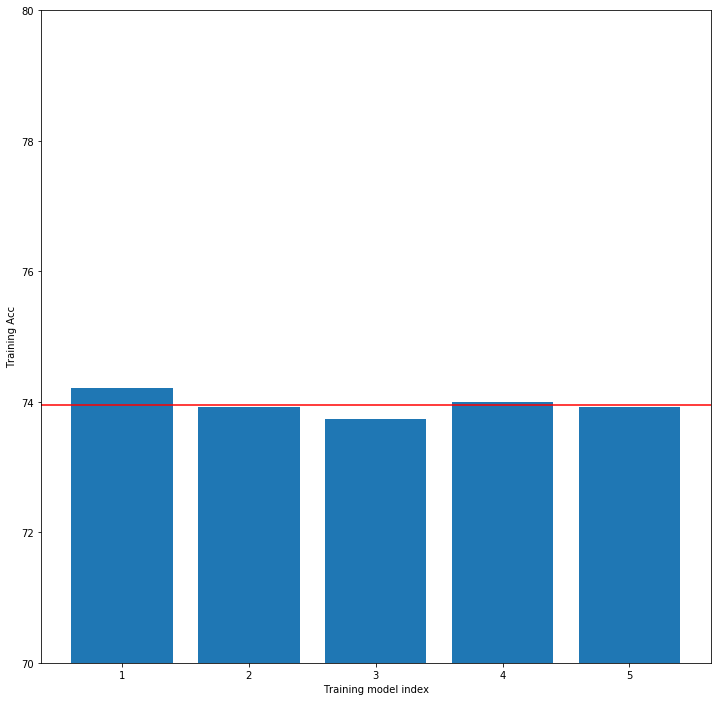

Average training acc: 73.9584


[74.22, 73.916, 73.742, 74.0, 73.914]

In [36]:
model_name = 'CIFAR17_add210'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc( model, train_data_loader,
                   model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN2

  1%|          | 15/1563 [00:00<00:10, 148.91it/s]

Trail 1


  1%|          | 18/1563 [00:00<00:08, 172.36it/s]

Test set: Average loss: 0.7492, Accuracy: 36846/50000 (74%)

Trail 2


  1%|          | 18/1563 [00:00<00:08, 172.79it/s]

Test set: Average loss: 0.7372, Accuracy: 37086/50000 (74%)

Trail 3


  1%|          | 18/1563 [00:00<00:08, 172.27it/s]

Test set: Average loss: 0.7431, Accuracy: 36895/50000 (74%)

Trail 4


  1%|          | 18/1563 [00:00<00:08, 171.93it/s]

Test set: Average loss: 0.7797, Accuracy: 36445/50000 (73%)

Trail 5


100%|██████████| 1563/1563 [00:09<00:00, 171.22it/s]


Test set: Average loss: 0.7310, Accuracy: 37277/50000 (75%)



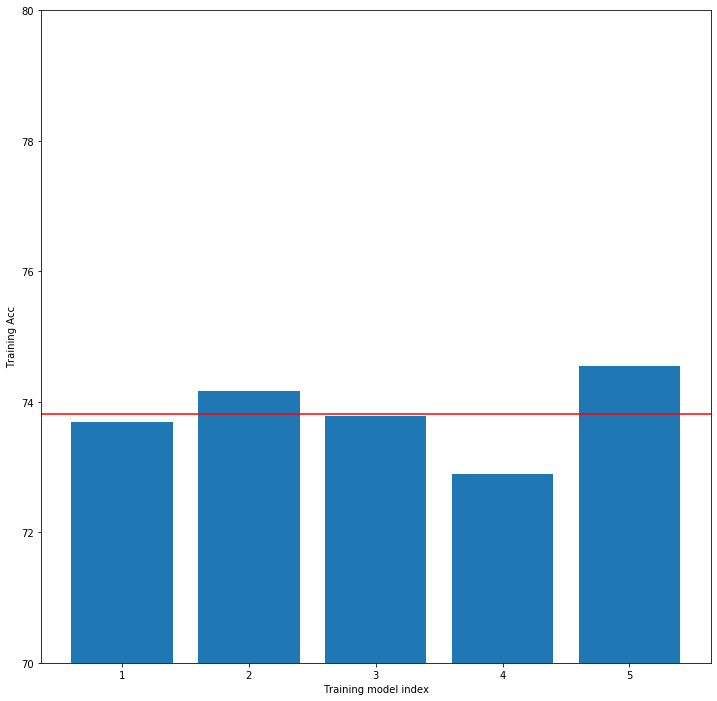

Average training acc: 73.8196


[73.692, 74.172, 73.79, 72.89, 74.554]

In [37]:
model_name = 'CIFAR17_add120'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  1%|          | 18/1563 [00:00<00:09, 170.66it/s]

Trail 1


  1%|          | 18/1563 [00:00<00:08, 174.67it/s]

Test set: Average loss: 0.8213, Accuracy: 35635/50000 (71%)

Trail 2


  1%|          | 18/1563 [00:00<00:08, 173.20it/s]

Test set: Average loss: 0.8037, Accuracy: 35811/50000 (72%)

Trail 3


  1%|          | 18/1563 [00:00<00:08, 176.00it/s]

Test set: Average loss: 0.8163, Accuracy: 35755/50000 (72%)

Trail 4


  1%|          | 18/1563 [00:00<00:08, 176.89it/s]

Test set: Average loss: 0.8108, Accuracy: 35733/50000 (71%)

Trail 5


100%|██████████| 1563/1563 [00:09<00:00, 173.54it/s]


Test set: Average loss: 0.8162, Accuracy: 35785/50000 (72%)



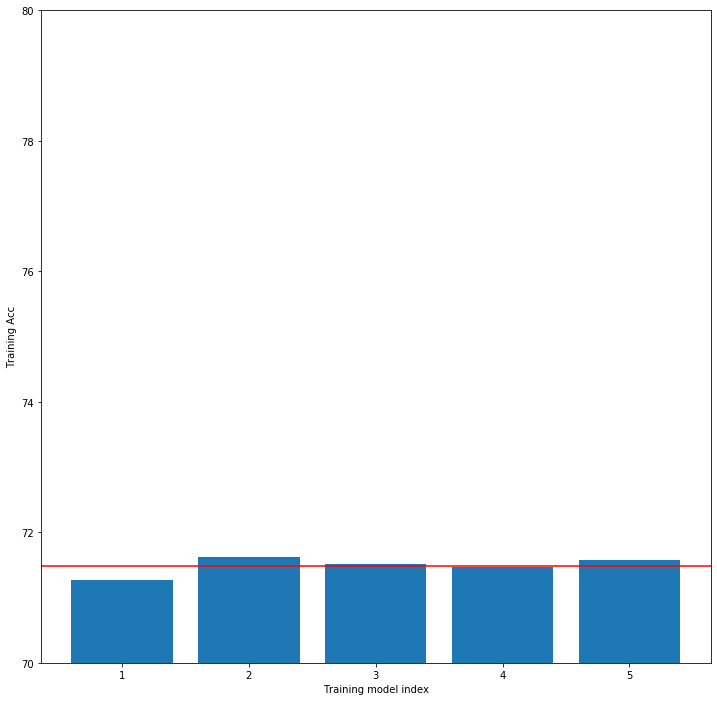

Average training acc: 71.4876


[71.27, 71.622, 71.51, 71.466, 71.57]

In [38]:
model_name = 'CIFAR17_add111'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', total_trails=5)

## Double the number of Conv filters

### Add to CNN1

In [35]:
model_name = 'CIFAR17_double1'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

TypeError: forward() missing 1 required positional argument: 'x'

### Add to CNN2

  1%|          | 11/1563 [00:00<00:15, 101.81it/s]

Trail 1


100%|██████████| 1563/1563 [00:12<00:00, 127.95it/s]


Test set: Average loss: 0.6700, Accuracy: 38133/50000 (76%)



  1%|          | 11/1563 [00:00<00:14, 109.59it/s]

Trail 2


  1%|          | 12/1563 [00:00<00:13, 115.55it/s]

Test set: Average loss: 0.6744, Accuracy: 38116/50000 (76%)

Trail 3


100%|██████████| 1563/1563 [00:12<00:00, 124.23it/s]


Test set: Average loss: 0.6689, Accuracy: 38182/50000 (76%)



  1%|          | 11/1563 [00:00<00:14, 106.75it/s]

Trail 4


100%|██████████| 1563/1563 [00:12<00:00, 128.54it/s]


Test set: Average loss: 0.6599, Accuracy: 38393/50000 (77%)



  1%|          | 11/1563 [00:00<00:14, 105.19it/s]

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 140.81it/s]


Test set: Average loss: 0.6662, Accuracy: 38159/50000 (76%)



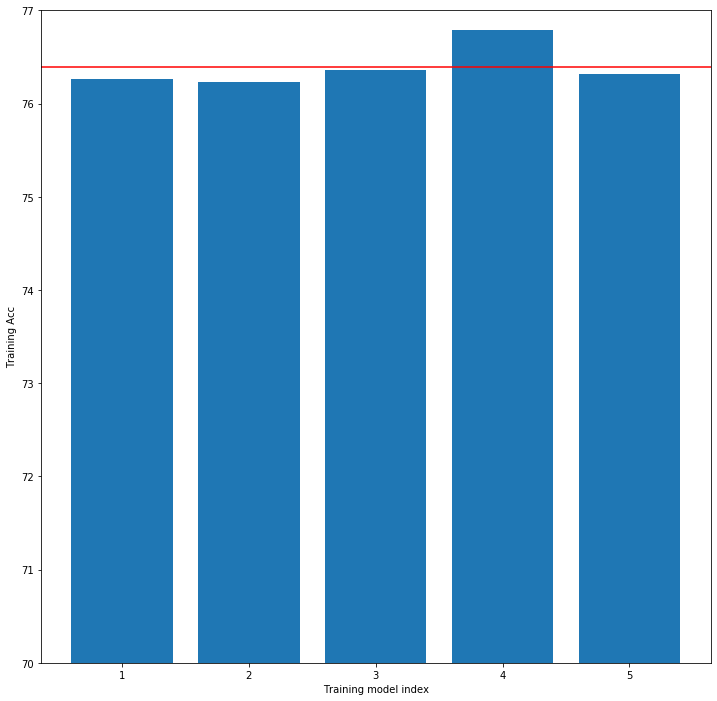

Average training acc: 76.39320000000001


[76.266, 76.232, 76.364, 76.786, 76.318]

In [20]:
model_name = 'CIFAR17_double2'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.6476, Accuracy: 38518/50000 (77%)

Trail 2


  1%|          | 12/1563 [00:00<00:13, 114.83it/s]

Test set: Average loss: 0.6163, Accuracy: 39054/50000 (78%)

Trail 3


  1%|          | 11/1563 [00:00<00:14, 109.65it/s]

Test set: Average loss: 0.6079, Accuracy: 39172/50000 (78%)

Trail 4


  1%|          | 9/1563 [00:00<00:18, 82.94it/s]

Test set: Average loss: 0.6350, Accuracy: 38701/50000 (77%)

Trail 5


100%|██████████| 1563/1563 [00:15<00:00, 98.79it/s] 


Test set: Average loss: 0.6217, Accuracy: 38862/50000 (78%)



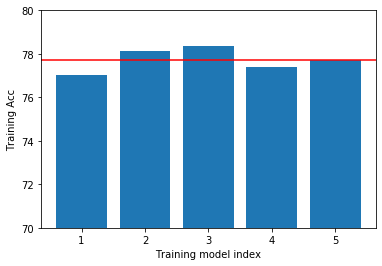

Average training acc: 77.72279999999999


[77.036, 78.108, 78.344, 77.402, 77.724]

In [6]:
model_name = 'CIFAR17_double3'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

## Increase Conv filter kernel size 

### Add to CNN1

  0%|          | 7/1563 [00:00<00:22, 69.86it/s]

Trail 1


100%|██████████| 1563/1563 [00:17<00:00, 87.57it/s] 


Test set: Average loss: 0.7452, Accuracy: 36855/50000 (74%)



  1%|          | 8/1563 [00:00<00:19, 78.77it/s]

Trail 2


100%|██████████| 1563/1563 [00:14<00:00, 106.99it/s]


Test set: Average loss: 0.7297, Accuracy: 37152/50000 (74%)



  1%|          | 9/1563 [00:00<00:18, 81.89it/s]

Trail 3


100%|██████████| 1563/1563 [00:15<00:00, 98.55it/s] 


Test set: Average loss: 0.7137, Accuracy: 37477/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 85.49it/s]

Trail 4


100%|██████████| 1563/1563 [00:15<00:00, 101.12it/s]


Test set: Average loss: 0.7053, Accuracy: 37584/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 79.68it/s]

Trail 5


100%|██████████| 1563/1563 [00:16<00:00, 95.06it/s] 


Test set: Average loss: 0.7346, Accuracy: 37182/50000 (74%)



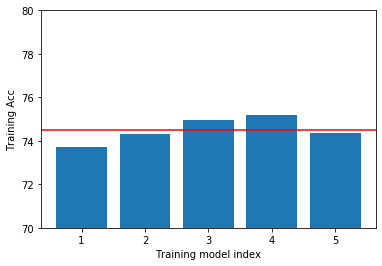

Average training acc: 74.5


[73.71, 74.304, 74.954, 75.168, 74.364]

In [7]:
model_name = 'CIFAR17_filter1'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN2

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  1%|          | 8/1563 [00:00<00:20, 77.40it/s]

Test set: Average loss: 0.6973, Accuracy: 37666/50000 (75%)

Trail 2


100%|██████████| 1563/1563 [00:14<00:00, 111.31it/s]


Test set: Average loss: 0.7096, Accuracy: 37575/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 80.13it/s]

Trail 3


100%|██████████| 1563/1563 [00:16<00:00, 96.85it/s] 


Test set: Average loss: 0.7072, Accuracy: 37488/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 84.23it/s]

Trail 4


  0%|          | 5/1563 [00:00<00:39, 39.60it/s]

Test set: Average loss: 0.7321, Accuracy: 36913/50000 (74%)

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 132.37it/s]


Test set: Average loss: 0.7144, Accuracy: 37320/50000 (75%)



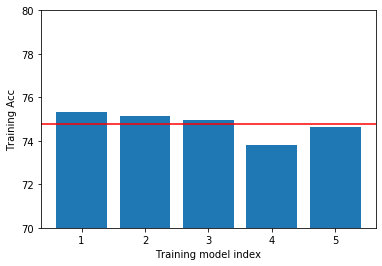

Average training acc: 74.78479999999999


[75.332, 75.15, 74.976, 73.826, 74.64]

In [8]:
model_name = 'CIFAR17_filter2'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  0%|          | 3/1563 [00:00<01:04, 24.31it/s]

Trail 1


100%|██████████| 1563/1563 [00:16<00:00, 97.08it/s] 


Test set: Average loss: 0.7022, Accuracy: 37538/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 81.39it/s]

Trail 2


100%|██████████| 1563/1563 [00:15<00:00, 101.36it/s]


Test set: Average loss: 0.7183, Accuracy: 37351/50000 (75%)



  1%|          | 8/1563 [00:00<00:21, 71.93it/s]

Trail 3


  1%|          | 9/1563 [00:00<00:18, 84.80it/s]

Test set: Average loss: 0.6819, Accuracy: 37926/50000 (76%)

Trail 4


100%|██████████| 1563/1563 [00:14<00:00, 104.41it/s]


Test set: Average loss: 0.6921, Accuracy: 37707/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 82.78it/s]

Trail 5


100%|██████████| 1563/1563 [00:17<00:00, 89.88it/s] 


Test set: Average loss: 0.6793, Accuracy: 37976/50000 (76%)



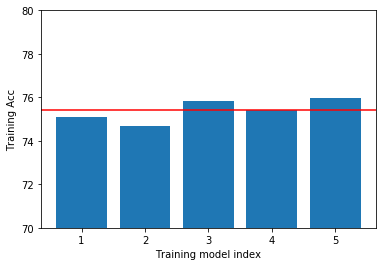

Average training acc: 75.3992


[75.076, 74.702, 75.852, 75.414, 75.952]

In [9]:
model_name = 'CIFAR17_filter3'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

In [50]:
neighbour_dict = [[1,0,0], [0,1,0], [0,0,1]]
a = [75.076, 74.702, 75.852]

In [51]:
np.asarray(neighbour_dict)[np.asarray(a) == max(a)][0]

array([0, 0, 1])